In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
import seaborn as sns
import numpy as np
#from Bio.SeqUtils.ProtParam import ProtParam
from sklearn.utils import resample
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
import re
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParam

In [81]:
def compute_ci(df, num_bootstraps, ci_level):
    corr_bootstraps = []
    num_cols = df.shape[1]
    
    for _ in range(num_bootstraps):
        df_boot = df.apply(lambda x: resample(x, replace=True, random_state=_))
        if num_cols > 1:
            corr_boot = df_boot.corr().values.flatten()
        else:
            corr_boot = np.array([1.0])
        corr_bootstraps.append(corr_boot)

    corr_bootstraps = np.array(corr_bootstraps)
    ci_lower = np.percentile(corr_bootstraps, (1 - ci_level) / 2 * 100, axis=0)
    ci_upper = np.percentile(corr_bootstraps, (1 + ci_level) / 2 * 100, axis=0)

    return ci_lower, ci_upper

aro_aa = ['F', "Y", "W", "H"]
def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def pearsonr_ci(x, y, alpha=0.05):
    r, p = stats.pearsonr(x, y)
    n = len(x)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    err = (hi - p) + (p - lo)
    return r, p, lo, hi,n, err

def plot_sig_boxplot(df, data_call, functional_column, predictor, title):
    df = df[df['predictor'] == predictor]
    group_0 = df[df[functional_column] == 'Neutral'][data_call]
    group_1 = df[df[functional_column] == 'Deleterious'][data_call]
    statistic, p_value = mannwhitneyu(group_0, group_1)
    ax = plt.gca()
    sns.boxplot(x=functional_column, y=data_call, data=df, ax=ax)
    ax.set_xlabel('Functional Classification', fontsize=14, fontweight='bold')  
    ax.set_ylabel('|ΔΔG|', fontsize=14, fontweight='bold')  
    plt.xticks(size=14)
    plt.tick_params(axis='x', width=2) 
    plt.tick_params(axis='y', width=2)
    ax.set_title(f'{predictor} |ΔΔG| in {title}', fontsize=14)  
    if p_value < 0.05:
        significant_combinations = [((0.25, 0.75), p_value)]  
        y_range = max(max(group_0), max(group_1)) - min(min(group_0), min(group_1))
        top = max(max(group_0), max(group_1))

        for i, significant_combination in enumerate(significant_combinations):
            x1 = significant_combination[0][0] - 0.1  
            x2 = significant_combination[0][1] + 0.1 
            level = len(significant_combinations) - i
            bar_height = (y_range * 0.07 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            ax.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
            p = significant_combination[1]
            if p < 0.001:
                sig_symbol = '***'
            elif p < 0.01:
                sig_symbol = '**'
            elif p < 0.05:
                sig_symbol = '*'
            text_height = bar_height + (y_range * 0.01)
            ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
            
def plot_sig_boxplot_ax(df, data_call, functional_column, predictor, ax):
    df = df[df['predictor'] == predictor]
    group_0 = df[df[functional_column] == 'Neutral'][data_call]
    group_1 = df[df[functional_column] == 'Deleterious'][data_call]
    statistic, p_value = mannwhitneyu(group_0, group_1)
    sns.boxplot(x=functional_column, y=data_call, data=df, ax=ax)
    ax.set_xlabel('Functional Classification', fontsize=14)  
    ax.set_ylabel(title, fontsize=14)  
    if p_value < 0.05:
        significant_combinations = [((0.25, 0.75), p_value)]  
        y_range = max(max(group_0), max(group_1)) - min(min(group_0), min(group_1))
        top = max(max(group_0), max(group_1))
        for i, significant_combination in enumerate(significant_combinations):
            x1 = significant_combination[0][0] - 0.1 
            x2 = significant_combination[0][1] + 0.1  
            level = len(significant_combinations) - i
            bar_height = (y_range * 0.07 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            ax.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
            p = significant_combination[1]
            if p < 0.001:
                sig_symbol = '***'
            elif p < 0.01:
                sig_symbol = '**'
            elif p < 0.05:
                sig_symbol = '*'
            text_height = bar_height + (y_range * 0.01)
            ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

In [82]:
BRCA1_ddg_results_df = pd.read_csv("BRCA1_data_function_ddg.csv")
BRCA2_ddg_results_df = pd.read_csv("BRCA2_data_function_ddg.csv")
PALB2_ddg_results_df = pd.read_csv("PALB2_data_function_ddg.csv")
RAD51C_ddg_results_df = pd.read_csv("RAD51C_data_function_ddg.csv")
ddg_results_df = pd.concat([BRCA1_ddg_results_df,BRCA2_ddg_results_df,
                           PALB2_ddg_results_df, RAD51C_ddg_results_df], axis=0)
ddg_results_df = ddg_results_df.reset_index(drop=True)
ddg_results_df[['struct_predictor', 'struct_type']] = ddg_results_df['dtype'].str.split('_', expand=True)
ddg_results_df['GENE_MODEL'] = ddg_results_df['GENE'] + "_" + ddg_results_df['model']
ddg_results_df['ΔΔG'] = ddg_results_df.ddg.abs()
#ddg_results_function_df = ddg_results_df[~ddg_results_df['HDR'].isna()]
ddg_results_function_df = ddg_results_df[~ddg_results_df['Class'].isna()]

ddg_results_function_df = ddg_results_function_df.reset_index(drop=True)
BRCA1_1JNX_crystal_df = ddg_results_function_df[(ddg_results_function_df['model'] == "1JNX") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
BRCA1_1JNX_AF2_df = ddg_results_function_df[(ddg_results_function_df['model'] == "1JNX") &
                                                                 (ddg_results_function_df['struct_predictor'] == "AF2")]
PALB2_2W18_crystal_df = ddg_results_function_df[(ddg_results_function_df['model'] == "2W18") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
PALB2_2W18_AF2_df = ddg_results_function_df[(ddg_results_function_df['model'] == "2W18") &
                                                                 (ddg_results_function_df['struct_predictor'] == "AF2")]
ddg_results_function_complex_crystal_df = ddg_results_function_df[(ddg_results_function_df['struct_type'] == "complex") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
ddg_results_function_complex_crystal_df = pd.concat([ddg_results_function_complex_crystal_df,
                                                    BRCA1_1JNX_crystal_df, PALB2_2W18_crystal_df], axis=0)
ddg_results_function_complex_AF2_df = ddg_results_function_df[(ddg_results_function_df['struct_type'] == "complex") &
                                                         (ddg_results_function_df['struct_predictor'] == "AF2")]
ddg_results_function_complex_AF2_df = pd.concat([ddg_results_function_complex_AF2_df,
                                                BRCA1_1JNX_AF2_df, PALB2_2W18_AF2_df], axis=0)
ddg_results_function_complex_AF2_df = ddg_results_function_complex_AF2_df[(ddg_results_function_complex_AF2_df['Class'] == 'Normal') |
                                                                         (ddg_results_function_complex_AF2_df['Class'] == 'Abnormal')]

ddg_results_function_complex_crystal_df = ddg_results_function_complex_crystal_df[(ddg_results_function_complex_crystal_df['Class'] == 'Normal') |
                                                                         (ddg_results_function_complex_crystal_df['Class'] == 'Abnormal')]

#PALB2_ddg_results_df[PALB2_ddg_results_df['model'] == "2W18"]
#PALB2_2W18_crystal_df
#ddg_results_function_complex_crystal_df[ddg_results_function_complex_crystal_df['model'] =='2W18']['Class'].value_counts()
ddg_results_function_complex_crystal_df.model.value_counts()

4OFB    3639
1T15    3624
1JNX    3596
7LYB    1662
1MJE     922
8FAZ     443
8OUZ     431
2W18     164
3EU7     142
Name: model, dtype: int64

In [84]:
grouped = ddg_results_function_complex_crystal_df.groupby(['GENE','model', 'predictor'])
def compute_midrank(x):

    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1
    return aucs[0], delongcov

def delong_pr_auc_variance(y_true, y_pred):
    order, label_1_count = compute_ground_truth_statistics(y_true)
    predictions_sorted_transposed = np.vstack((y_pred, y_pred))[:, order]
    pr_aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    #pr_aucs = average_precision_score
    return pr_aucs[0], delongcov

def compute_pr_auc_ci(y_true, y_pred, n_bootstrap=1000, alpha=0.95):
    pr_auc, pr_auc_cov = delong_pr_auc_variance(y_true, y_pred)
    pr_auc_std = np.sqrt(pr_auc_cov)
    pr_auc_samples = []
    for _ in range(n_bootstrap):
        y_true_boot, y_pred_boot = resample(y_true, y_pred)
        pr_auc_boot = average_precision_score(y_true_boot, y_pred_boot)
        pr_auc_samples.append(pr_auc_boot)
    lower_quantile = (1 - alpha) / 2.0 * 100
    upper_quantile = (alpha + (1 - alpha) / 2.0) * 100
    ci = np.percentile(pr_auc_samples, [lower_quantile, upper_quantile])
    
    return pr_auc, pr_auc_std, ci


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


#pr_auc_results = []

# Iterate over each group
#for (GENE, model, predictor), group_df in grouped:
#    y_true = group_df['Class'].map({'Normal': 0, 'Abnormal': 1})
#    y_pred = group_df['ΔΔG']
    
    # Compute PR-AUC and confidence interval
#    pr_auc, pr_auc_std, ci = compute_pr_auc_ci(y_true, y_pred)
    
    # Append the results to the list
#    pr_auc_results.append({
#        'Gene': GENE,
#        'Model': model,
#        'Predictor': predictor,
#        'PR_AUC': pr_auc,
#        'PR_AUC_CI_Lower': ci[0],
#        'PR_AUC_CI_Upper': ci[1]
#    })

# Convert the list of dictionaries to a DataFrame
#pr_auc_df = pd.DataFrame(pr_auc_results)

# Display the DataFrame
#print(pr_auc_df)
auc_results = []

for (GENE, model, predictor), group_df in grouped:
    y_true = group_df['Class'].map({'Normal': 0, 'Abnormal': 1})
    alpha = .95
    y_pred = group_df['ΔΔG']
    auc, auc_cov = delong_roc_variance(y_true,y_pred)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q,loc=auc,scale=auc_std)
    ci[ci > 1] = 1
    auc_results.append({'Gene': GENE,
                        'Model': model,
                        'Predictor': predictor,
                        'AUC': auc,
                        'AUC_CI_Lower': ci[0],
                        'AUC_CI_Upper': ci[1]})
auc_df = pd.DataFrame(auc_results)
print(auc_df)

      Gene Model Predictor       AUC  AUC_CI_Lower  AUC_CI_Upper
0    BRCA1  1JNX   DDgun3D  0.739541      0.704506      0.774577
1    BRCA1  1JNX     FoldX  0.808375      0.775725      0.841025
2    BRCA1  1JNX   Rosetta  0.735835      0.703857      0.767813
3    BRCA1  1T15   DDgun3D  0.748952      0.715347      0.782557
4    BRCA1  1T15     FoldX  0.845486      0.817625      0.873346
5    BRCA1  1T15   Rosetta  0.767974      0.737236      0.798711
6    BRCA1  4OFB   DDgun3D  0.749068      0.714698      0.783437
7    BRCA1  4OFB     FoldX  0.852366      0.825037      0.879694
8    BRCA1  4OFB   Rosetta  0.766852      0.736747      0.796957
9    BRCA1  7LYB   DDgun3D  0.757565      0.704498      0.810631
10   BRCA1  7LYB     FoldX  0.837118      0.788226      0.886009
11   BRCA1  7LYB   Rosetta  0.705970      0.653541      0.758399
12   BRCA2  1MJE   DDgun3D  0.777570      0.720810      0.834331
13   BRCA2  1MJE     FoldX  0.829911      0.780233      0.879590
14   BRCA2  1MJE   Rosett

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:59: De

In [85]:

grouped_AUC_df = auc_df.groupby(['Predictor','Gene']).agg({
    'AUC': 'mean',
    'AUC_CI_Lower': 'mean',
    'AUC_CI_Upper': 'mean'
}).reset_index()
print(grouped_AUC_df)

   Predictor    Gene       AUC  AUC_CI_Lower  AUC_CI_Upper
0    DDgun3D   BRCA1  0.748781      0.709762      0.787800
1    DDgun3D   BRCA2  0.777570      0.720810      0.834331
2    DDgun3D   PALB2  0.835227      0.676771      0.993683
3    DDgun3D  RAD51C  0.702402      0.609867      0.794938
4      FoldX   BRCA1  0.835836      0.801653      0.870019
5      FoldX   BRCA2  0.829911      0.780233      0.879590
6      FoldX   PALB2  0.724351      0.482108      0.947053
7      FoldX  RAD51C  0.783919      0.675071      0.892767
8    Rosetta   BRCA1  0.744158      0.707845      0.780470
9    Rosetta   BRCA2  0.758799      0.702191      0.815406
10   Rosetta   PALB2  0.592532      0.371915      0.813150
11   Rosetta  RAD51C  0.769764      0.677429      0.862100


In [86]:
model_genes = ['BRCA1_4OFB', 'BRCA1_7LYB', 'BRCA1_1JNX', 'BRCA2_1MJE',
              'RAD51C_8FAZ', 'PALB2_3EU7', 'PALB2_2W18']
genes = ['BRCA1', 'BRCA2', 'PALB2', "RAD51C"]
predictors = ['FoldX', 'Rosetta', "DDgun3D"]
complex_structures = ['crystal', 'AF2']
#for model_gene in model_genes:
#    model_gene_df = ddg_results_function_complex_crystal_df[ddg_results_function_complex_crystal_df['GENE_MODEL'] == 'model_gene']
#    plt.figure(figsize=(15, 5))
#    plt.subplot(1, 3, 1)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'FoldX', model_gene)
#    plt.subplot(1, 3, 2)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'Rosetta', model_gene)
#    plt.subplot(1, 3, 3)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'DDgun3D', model_gene)
#    plt.tight_layout()
#    plt.show()

ddg_results_exp0_df = ddg_results_function_complex_crystal_df[['mutations', 'GENE', 'ΔΔG', 'predictor', 'Class']]
ddg_results_exp0_df['labels'] = ddg_results_exp0_df['Class'].apply(lambda x: 'Deleterious' if x=="Abnormal" else 'Neutral')
for gene in genes:
    plt.figure(figsize=(16, 5))
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'FoldX', gene)
    plt.subplot(1, 3, 2)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'Rosetta', gene)
    plt.subplot(1, 3, 3)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'DDgun3D', gene)
    plt.savefig(f'{gene}_boxplots.png', dpi=300)
    plt.close(fig) 

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

In [87]:
model_genes = ['BRCA1_4OFB', 'BRCA1_7LYB', 'BRCA1_1JNX', 'BRCA1_1T15','BRCA2_1MJE',
              'RAD51C_8FAZ', 'RAD51C_8OUZ', 'PALB2_3EU7', 'PALB2_2W18']
predictors = ['FoldX', 'Rosetta', "DDgun3D"]
complex_structures = ['crystal', 'AF2']


In [88]:
pcc_crystal_df = pd.DataFrame(columns=['Feature', 'PCC', 'P-Value', 'Lower Bound', 
                                       'Upper Bound', 'MODEL GENE', 'COMPLEX'])

for model_gene in model_genes:
    for predictor in predictors:
        model_gene_df = ddg_results_function_complex_crystal_df[
            (ddg_results_function_complex_crystal_df['GENE_MODEL'] == model_gene) &
            (ddg_results_function_complex_crystal_df['predictor'] == predictor)]
        model_gene_df = model_gene_df[~model_gene_df['HDR'].isna()]
        pcc, p_value, lo, hi,n, err = pearsonr_ci(model_gene_df.ΔΔG, model_gene_df.HDR)
        pcc_crystal_df = pcc_crystal_df.append({'Feature': predictor, 
                                'PCC': pcc,
                                'P-Value': p_value, 
                                'Lower Bound': lo,
                                'Upper Bound': hi, 
                                'MODEL GENE': model_gene, 'Total': n}, ignore_index=True)


pcc_crystal_df = pcc_crystal_df.sort_values(['PCC'], ascending=False)
pcc_crystal_df[['GENE', 'PDB']] = pcc_crystal_df['MODEL GENE'].str.split('_', expand=True)
genes = ['BRCA1', 'BRCA2', "PALB2", 'RAD51C']

pcc_crystal_df['COMPLEX'] = 'crystal'



pcc_AF2_df = pd.DataFrame(columns=['Feature', 'PCC', 'P-Value', 'Lower Bound', 
                                   'Upper Bound', 'MODEL GENE', 'COMPLEX'])

for model_gene in model_genes:
    for predictor in predictors:
        print(model_gene, predictor)
        model_gene_df = ddg_results_function_complex_AF2_df[
            (ddg_results_function_complex_AF2_df['GENE_MODEL'] == model_gene) &
            (ddg_results_function_complex_AF2_df['predictor'] == predictor)]
        model_gene_df = model_gene_df[~model_gene_df['HDR'].isna()]
        pcc, p_value, lo, hi, n, err = pearsonr_ci(model_gene_df.ΔΔG, model_gene_df.HDR)
        pcc_AF2_df = pcc_AF2_df.append({'Feature': predictor, 
                                        'PCC': pcc,
                                        'P-Value': p_value, 
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'MODEL GENE': model_gene, 'Total': n}, ignore_index=True)


pcc_AF2_df = pcc_AF2_df.sort_values(['PCC'], ascending=False)
pcc_AF2_df[['GENE', 'PDB']] = pcc_AF2_df['MODEL GENE'].str.split('_', expand=True)
genes = ['BRCA1', 'BRCA2', "PALB2", 'RAD51C']

pcc_AF2_df['COMPLEX'] = 'AF2'
pcc_AF2_df = pcc_AF2_df.sort_values(['PCC'], ascending=False)
pcc_AF2_df = pcc_AF2_df.reset_index(drop=True)
pcc_df = pd.concat([pcc_AF2_df, pcc_crystal_df], axis=0)
pcc_df = pcc_df.sort_values(['PCC'], ascending=False)
pcc_df = pcc_df.reset_index(drop=True)
pcc_df['Lower Error'] = pcc_df['PCC'] - pcc_df['Lower Bound']
pcc_df['Upper Error'] = pcc_df['Upper Bound'] - pcc
pcc_df['err'] = pcc_df['Upper Error']  - pcc_df['Lower Error']
pcc_ddgun_df = pcc_df[pcc_df['Feature'] == 'DDgun3D']
pcc_ddgun_df

BRCA1_4OFB FoldX
BRCA1_4OFB Rosetta
BRCA1_4OFB DDgun3D
BRCA1_7LYB FoldX
BRCA1_7LYB Rosetta
BRCA1_7LYB DDgun3D
BRCA1_1JNX FoldX
BRCA1_1JNX Rosetta
BRCA1_1JNX DDgun3D
BRCA1_1T15 FoldX
BRCA1_1T15 Rosetta
BRCA1_1T15 DDgun3D
BRCA2_1MJE FoldX
BRCA2_1MJE Rosetta
BRCA2_1MJE DDgun3D
RAD51C_8FAZ FoldX
RAD51C_8FAZ Rosetta
RAD51C_8FAZ DDgun3D
RAD51C_8OUZ FoldX
RAD51C_8OUZ Rosetta
RAD51C_8OUZ DDgun3D
PALB2_3EU7 FoldX
PALB2_3EU7 Rosetta
PALB2_3EU7 DDgun3D
PALB2_2W18 FoldX
PALB2_2W18 Rosetta
PALB2_2W18 DDgun3D


,Feature,PCC,P-Value,Lower Bound,Upper Bound,MODEL GENE,COMPLEX,Total,GENE,PDB,Lower Error,Upper Error,err
4,DDgun3D,-0.254799,1.982513e-03,-0.401146,-0.095767,RAD51C_8FAZ,crystal,145.0,RAD51C,8FAZ,0.146348,0.281442,0.135094
5,DDgun3D,-0.255369,2.160760e-03,-0.403138,-0.094622,RAD51C_8OUZ,crystal,142.0,RAD51C,8OUZ,0.147769,0.282587,0.134818
8,DDgun3D,-0.271711,1.028321e-03,-0.417250,-0.112584,RAD51C_8FAZ,AF2,143.0,RAD51C,8FAZ,0.145539,0.264625,0.119086
10,DDgun3D,-0.277189,8.390365e-04,-0.422620,-0.117843,RAD51C_8OUZ,AF2,142.0,RAD51C,8OUZ,0.145430,0.259366,0.113936
21,DDgun3D,-0.362039,2.352392e-02,-0.608094,-0.052522,PALB2_3EU7,AF2,39.0,PALB2,3EU7,0.246055,0.324687,0.078632
23,DDgun3D,-0.376952,1.800697e-02,-0.618865,-0.069728,PALB2_2W18,crystal,39.0,PALB2,2W18,0.241913,0.307481,0.065568
24,DDgun3D,-0.377209,1.792243e-02,-0.619049,-0.070026,PALB2_2W18,AF2,39.0,PALB2,2W18,0.241840,0.307183,0.065342
28,DDgun3D,-0.419678,3.210085e-52,-0.465293,-0.371839,BRCA1_1JNX,crystal,1196.0,BRCA1,1JNX,0.045615,0.005369,-0.040246
29,DDgun3D,-0.423519,2.533532e-54,-0.468489,-0.376361,BRCA1_1T15,AF2,1221.0,BRCA1,1T15,0.044970,0.000848,-0.044121
30,DDgun3D,-0.424053,2.187443e-02,-0.684219,-0.068138,PALB2_3EU7,crystal,29.0,PALB2,3EU7,0.260166,0.309071,0.048906


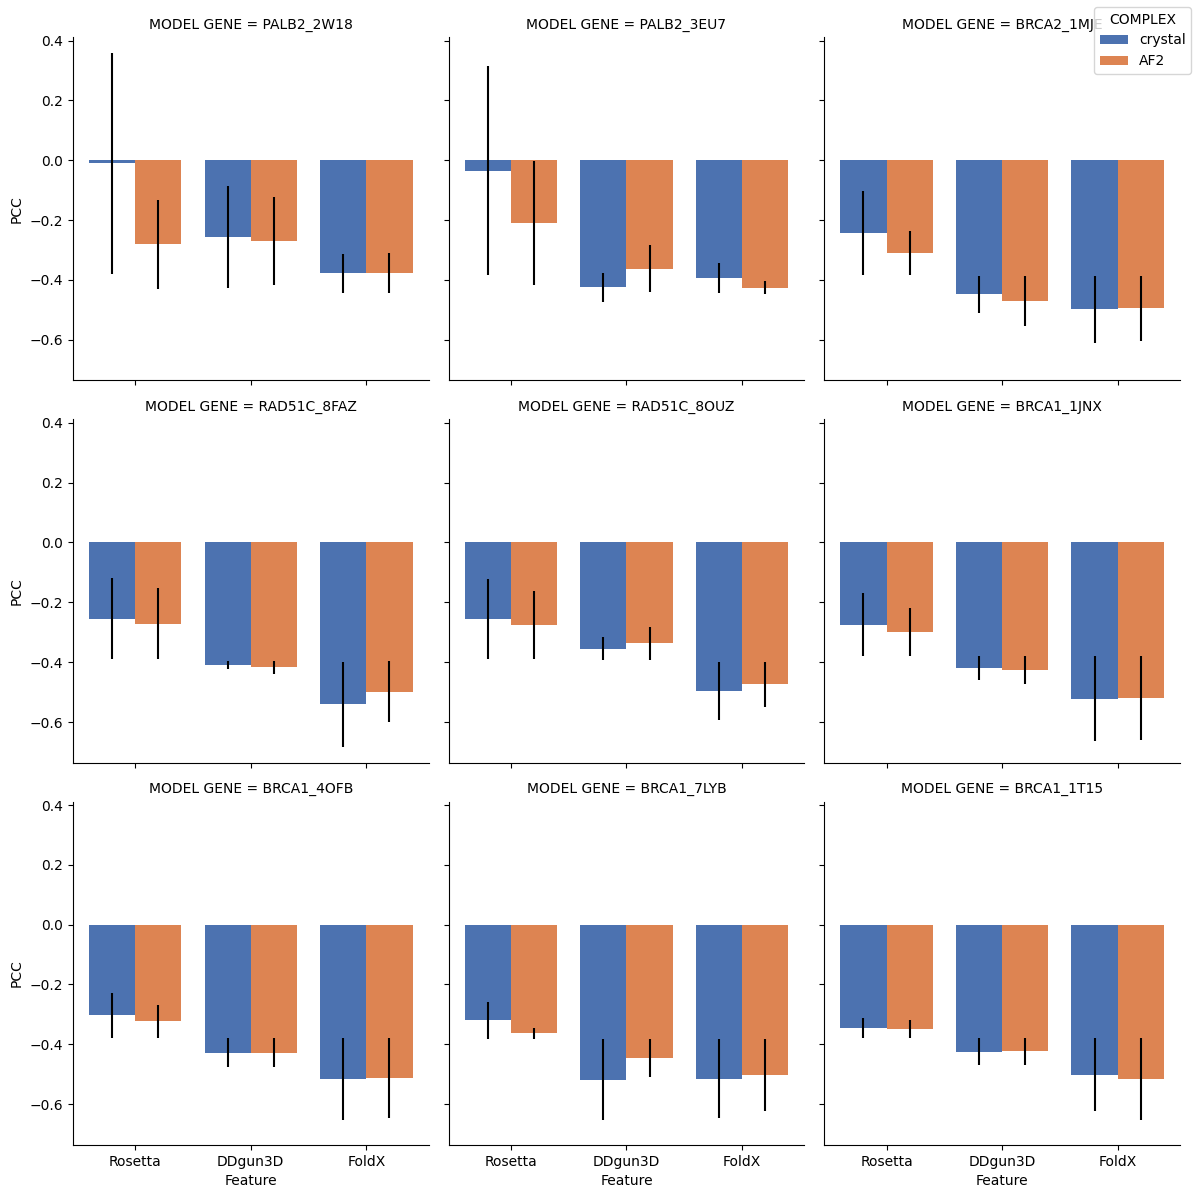

In [92]:
def errplot(x, y, data, hue, yerr, palette='deep', color=None):
    hues = data[hue].unique()
    dodge_width = 0.8
    dodge_vals = np.linspace(-dodge_width / 2, dodge_width / 2, len(hues)*2+1)[1::2]
    colors = sns.color_palette(palette, len(hues))
    xs = np.arange(len(data[x].unique()))  
    for hue_val, dodge_val, c in zip(hues, dodge_vals, colors):
        ys = [data[(data[x] == xi) & (data[hue] == hue_val)][y].to_numpy()[0] for xi in data[x].unique()]
        yerrs = [data[(data[x] == xi) & (data[hue] == hue_val)][yerr].to_numpy()[0] for xi in data[x].unique()]
        plt.bar(x=xs + dodge_val, height=ys, yerr=yerrs, width=dodge_width / len(hues), color=c, label=hue_val)
    plt.xticks(xs, data[x].unique())


In [93]:
ddg_results_nofunction_df = ddg_results_df[['mutations', 'GENE_MODEL', 'predictor', 'dtype','struct_type', 'struct_predictor', 'ΔΔG']]
ddg_results_nofunction_df = ddg_results_nofunction_df[(ddg_results_nofunction_df['struct_type'] == 'complex') |
                                                     (ddg_results_nofunction_df['GENE_MODEL'] == 'BRCA1_1JNX') |
                                                      (ddg_results_nofunction_df['GENE_MODEL'] == 'PALB2_2W18')]

pivot_df = ddg_results_nofunction_df.pivot_table(index=['mutations', 'GENE_MODEL'], columns=['predictor', 'struct_predictor'], values='ΔΔG', aggfunc='first').reset_index()

pivot_df.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in pivot_df.columns]
pivot_df = pivot_df.dropna()
def compute_deltas(df, column1, column2, name):
    df[name] = df[column1] - df[column2]
    return df

pivot_delta_df = compute_deltas(pivot_df, 'FoldX_AF2', 'FoldX_crystal', 'delta_FoldX')
pivot_delta_df = compute_deltas(pivot_delta_df, 'DDgun3D_AF2', 'DDgun3D_crystal', 'delta_DDgun3D')
pivot_delta_df = compute_deltas(pivot_delta_df, 'Rosetta_AF2', 'Rosetta_crystal', 'delta_Rosetta')
pivot_delta_df['REF_POS'] = pivot_delta_df['mutations'].str[:-1]

,mutations,GENE_MODEL,DDgun3D_AF2,DDgun3D_crystal,FoldX_AF2,FoldX_crystal,Rosetta_AF2,Rosetta_crystal,delta_FoldX,delta_DDgun3D,delta_Rosetta,REF_POS
0,A1017A,PALB2_2W18,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,1.314746e-12,0.000000e+00,0.0,-1.314746e-12,A1017
1,A1017A,PALB2_3EU7,0.0,0.0,3.410608e-13,2.273740e-14,0.000000,0.000000e+00,3.183234e-13,0.0,0.000000e+00,A1017
2,A1017C,PALB2_2W18,0.6,0.6,1.840403e-01,3.376808e-01,8.851464,4.199051e+01,-1.536405e-01,0.0,-3.313905e+01,A1017
3,A1017C,PALB2_3EU7,0.6,0.7,3.607872e-02,5.104160e-01,3.873989,3.843509e+00,-4.743373e-01,-0.1,3.048024e-02,A1017
4,A1017D,PALB2_2W18,3.2,3.1,4.822120e+00,2.475000e+00,29.227621,4.154309e+01,2.347120e+00,0.1,-1.231547e+01,A1017
...,...,...,...,...,...,...,...,...,...,...,...,...
52918,Y929V,PALB2_3EU7,0.4,0.4,3.042432e-01,3.258472e-01,1.357790,9.106499e-01,-2.160400e-02,0.0,4.471397e-01,Y929
52919,Y929W,PALB2_2W18,0.1,0.1,3.017496e-01,2.321112e-01,1.440396,1.501954e+00,6.963840e-02,0.0,-6.155721e-02,Y929
52920,Y929W,PALB2_3EU7,0.1,0.1,1.093089e-01,1.112374e+00,1.333113,4.394165e+00,-1.003065e+00,0.0,-3.061053e+00,Y929
52921,Y929Y,PALB2_2W18,0.0,0.0,3.088532e-03,3.018550e-03,0.000000,0.000000e+00,6.998174e-05,0.0,0.000000e+00,Y929


PALB2_3EU7 0.8789433957501542 0.9375198108574315 0.0 5045 0.8694181482803783 0.17075886054355482 (0.8605107607985873, 0.8783255357621693)
RAD51C_8OUZ 0.7744951673701562 0.880054070708247 0.0 5440 0.7913705176526206 0.32981683489308233 (0.7800184858199148, 0.8027225494853263)
PALB2_2W18 0.7355565267491755 0.857645921548733 0.0 5832 0.8908248792563597 0.3413694409813406 (0.8771111767597699, 0.9045385817529494)
BRCA1_1JNX 0.8591963858227136 0.926928468557695 0.0 4139 0.8562815226931544 0.2040762302095156 (0.8457155456313875, 0.8668474997549213)
BRCA1_4OFB 0.9122280481881218 0.9551063020356015 0.0 4179 0.8974919892896994 0.08496268547955665 (0.8890470124223561, 0.9059369661570428)
BRCA1_7LYB 0.22991131562711728 0.4794906835665499 4.894170767209701e-83 1429 0.6462879003975049 0.8936462292435983 (0.5848663405019827, 0.7077094602930272)
BRCA2_1MJE 0.5115349038662393 0.7152166831570971 0.0 11849 0.7417969805240617 0.3644057121121922 (0.7287427143912144, 0.7548512466569091)
BRCA1_1T15 0.9235981

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args

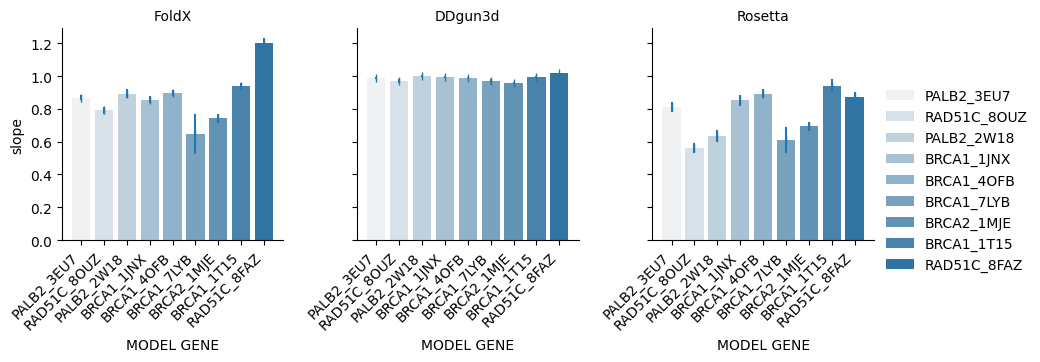

In [94]:


pcc_ddg_df = pd.DataFrame(columns=['MODEL GENE', 'PCC', 'P-Value', 'Lower Bound', 'Upper Bound'])

def spearmanr_ci(x, y, alpha=0.05):
    r, p = stats.spearmanr(x, y)
    n = len(x)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    err = (hi - p) + (p - lo)
    return r, p, lo, hi,n, err

def compute_r2_p(df, col1, col2):
    data = df[[col1, col2]].dropna()
    total = len(data)
    slope, intercept, r_value, p_value, std_err = linregress(data[col1], data[col2])
    r_squared = r_value ** 2
    t_value = t.ppf(0.975, df=len(data) - 2) 
    slope_ci = (slope - t_value * std_err, slope + t_value * std_err)
    intercept_ci = (intercept - t_value * std_err, intercept + t_value * std_err)
    return r_squared, r_value, p_value, total, slope, intercept, slope_ci
    
model_list = list(set(pivot_delta_df.GENE_MODEL.tolist()))
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    #print(model_df)
    r_squared, r_value, p_value, total, slope, intercept, slope_ci = compute_r2_p(model_df,
                                                                                  'FoldX_AF2',
                                                                                  'FoldX_crystal')
    print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'FoldX'}, ignore_index=True)

    
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    r_squared, r_value, p_value, total, slope, intercept, slope_ci = compute_r2_p(model_df, 'DDgun3D_AF2',
                                                                                  'DDgun3D_crystal')
    #print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'DDgun3d'}, ignore_index=True)

    
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    r_squared, r_value, p_value, total, slope, intercept, slope_ci  = compute_r2_p(model_df,
                                                                                   'Rosetta_AF2',
                                                                                   'Rosetta_crystal')
    #print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'Rosetta'}, ignore_index=True)

pcc_ddg_df['CI'] =   (pcc_ddg_df['Upper Bound'] - pcc_ddg_df['slope']) + (pcc_ddg_df['slope'] - pcc_ddg_df['Lower Bound'])
#pcc_ddg_df
g = sns.FacetGrid(pcc_ddg_df, col="predictor", height=3, col_wrap=3)
g.map_dataframe(sns.barplot, y='slope', x='MODEL GENE', hue='MODEL GENE', dodge=False)
g.map(plt.errorbar, "MODEL GENE", "slope", "CI", marker="|", fmt='o')

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.set_titles("{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.9)  

plt.show()

In [98]:

def calculate_molecular_weight(aa):
    protein = ProteinAnalysis(aa) 
    molecular_weight = protein.molecular_weight()
    return molecular_weight

def calculate_aromaticity(aa):
    protein = ProteinAnalysis(aa) 
    aromaticity = protein.aromaticity()
    return aromaticity


def calculate_instability_index(aa):
    protein = ProteinAnalysis(aa) 
    instability_index = protein.instability_index()
    return instability_index

def calculate_flexibility(aa):
    protein = ProteinAnalysis(aa) 
    flexibility = protein.flexibility()
    return flexibility

def calculate_isoelectric_point(aa):
    protein = ProteinAnalysis(aa) 
    isoelectric_point = protein.isoelectric_point()
    return isoelectric_point

def calculate_gravy(aa):
    protein = ProteinAnalysis(aa) 
    gravy = protein.gravy()
    return gravy

def generate_properties(df):
    df['AA_weight'] = df['Amino_acid'].apply(lambda x: calculate_molecular_weight(x))
    df['aromaticity'] = df['Amino_acid'].apply(lambda x: calculate_aromaticity(x))
#BRCA1_1JNX_features_df['flexibility'] = BRCA1_1JNX_features_df['Amino_acid'].apply(lambda x: calculate_flexibility(x))
    df['isoelectric_point'] = df['Amino_acid'].apply(lambda x: calculate_isoelectric_point(x))
    df['gravy'] = df['Amino_acid'].apply(lambda x: calculate_gravy(x))
    df['instability_index'] = df['Amino_acid'].apply(lambda x: calculate_instability_index(x))
    return df

In [99]:
BRCA1_4OFB_features_df = pd.read_csv("BRCA1_4OFB_plddt_distance.csv", sep='\t')
BRCA1_7LYB_features_df = pd.read_csv("BRCA1_7LYB_plddt_distance.csv", sep='\t')
BRCA1_1JNX_features_df = pd.read_csv("BRCA1_1JNX_plddt_distance.csv", sep='\t')
BRCA2_1MJE_features_df = pd.read_csv("BRCA2_1MJE_plddt_distance.csv", sep='\t')
PALB2_3EU7_features_df = pd.read_csv("PALB2_3EU7_plddt_distance.csv", sep='\t')
RAD51C_8FAZ_features_df = pd.read_csv("RAD51C_8FAZ_plddt_distance.csv", sep='\t')
PALB2_2W18_features_df = pd.read_csv("PALB2_2W18_plddt_distance.csv", sep='\t')
BRCA1_1T15_features_df = pd.read_csv("BRCA1_1T15_plddt_distance.csv", sep='\t')
RAD51C_8OUZ_features_df = pd.read_csv("RAD51C_8OUZ_plddt_distance.csv", sep='\t')

BRCA1_4OFB_features_df = generate_properties(BRCA1_4OFB_features_df) 
BRCA1_1T15_features_df = generate_properties(BRCA1_1T15_features_df) 
BRCA1_7LYB_features_df = generate_properties(BRCA1_7LYB_features_df)
BRCA1_1JNX_features_df = generate_properties(BRCA1_1JNX_features_df)
BRCA2_1MJE_features_df = generate_properties(BRCA2_1MJE_features_df)
PALB2_3EU7_features_df = generate_properties(PALB2_3EU7_features_df)
RAD51C_8OUZ_features_df = generate_properties(RAD51C_8OUZ_features_df)
RAD51C_8FAZ_features_df = generate_properties(RAD51C_8FAZ_features_df)
PALB2_2W18_features_df = generate_properties(PALB2_2W18_features_df)
BRCA1_4OFB_features_df

,REF_POS,PLDDT,Amino_acid,Secondary_structure,Relative_ASA,Mean_Distance,local_area_diff,group,distance,GENE,AA_weight,aromaticity,isoelectric_point,gravy,instability_index
0,R1649,90.81,R,C,1.000000,2.412661,NaN,NaN,NaN,BRCA1,174.2010,0.0,9.750021,-4.5,0.0
1,M1650,97.69,M,C,0.220588,1.064326,0.414718,4OFB,2.0,BRCA1,149.2113,0.0,5.275022,1.9,0.0
2,M1650,97.69,M,C,0.220588,1.064326,0.368467,4OFB,3.0,BRCA1,149.2113,0.0,5.275022,1.9,0.0
3,S1651,98.50,S,S,0.098361,1.218518,0.165143,4OFB,2.0,BRCA1,105.0926,0.0,5.240009,-0.8,0.0
4,S1651,98.50,S,S,0.098361,1.218518,0.172588,4OFB,3.0,BRCA1,105.0926,0.0,5.240009,-0.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,P1856,92.69,P,C,0.720280,1.081985,0.132604,4OFB,5.0,BRCA1,115.1305,0.0,5.954987,-1.6,0.0
1215,Q1857,91.69,Q,C,0.291005,1.502803,0.151168,4OFB,2.0,BRCA1,146.1445,0.0,5.525000,-3.5,0.0
1216,Q1857,91.69,Q,C,0.291005,1.502803,0.155993,4OFB,3.0,BRCA1,146.1445,0.0,5.525000,-3.5,0.0
1217,I1858,86.19,I,C,0.434066,1.677972,-0.058635,4OFB,2.0,BRCA1,131.1729,0.0,5.525000,4.5,0.0


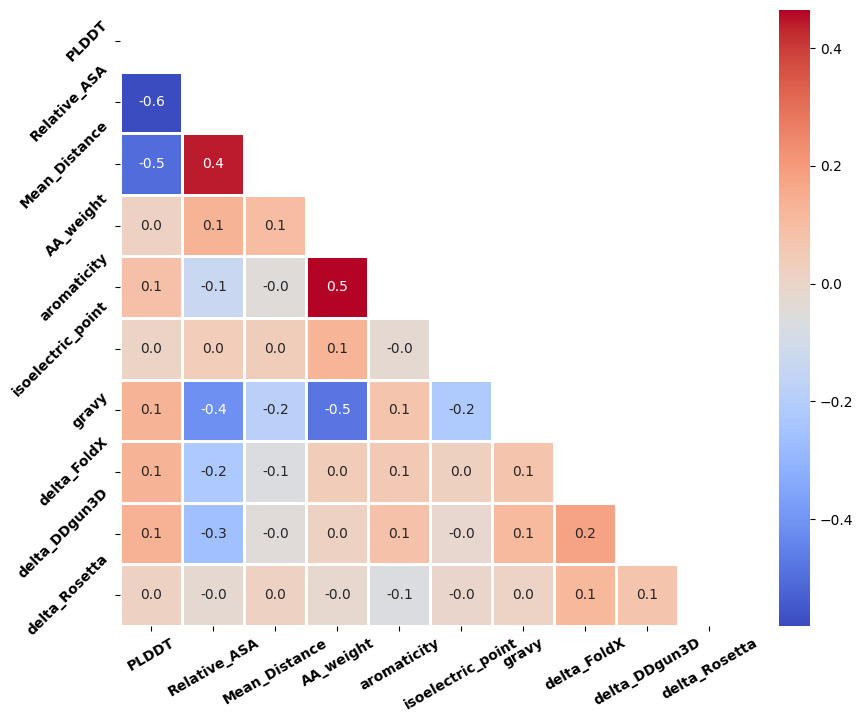

In [102]:
BRCA2_ddg_1MJE_results_df = ddg_results_df[ddg_results_df['model'] =='1MJE']
BRCA2_1MJE_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA2_1MJE"]
BRCA2_ddg_1MJE_results_feature_df = pd.merge(BRCA2_1MJE_features_df, BRCA2_1MJE_delta_df, on='REF_POS')


BRCA2_ddg_1MJE_results_feature_df.columns
metrics_column = ['PLDDT', 'Relative_ASA', 'Mean_Distance', 
                   'AA_weight', 'aromaticity',
                 'isoelectric_point', 'gravy', 'delta_FoldX', 
                  'delta_DDgun3D', 'delta_Rosetta']

BRCA2_1MJE_feature_only_df = BRCA2_ddg_1MJE_results_feature_df[metrics_column]
BRCA2_1MJE_feature_only_df = BRCA2_1MJE_feature_only_df.drop_duplicates()
BRCA2_1MJE_feature_only_df = BRCA2_1MJE_feature_only_df.reset_index(drop=True)
BRCA2_1MJE_feature_only_df

corr = BRCA2_1MJE_feature_only_df.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", linewidths=1, mask=mask)
plt.xticks(fontweight='bold', rotation=30)  # Rotate x-axis labels by 45 degrees
plt.yticks(fontweight='bold', rotation=45) 
plt.savefig('pyramid_heatmap.png', dpi=300)

plt.show()

In [103]:
BRCA1_ddg_7LYB_results_df = ddg_results_df[ddg_results_df['model'] =='7LYB']
BRCA1_7LYB_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_7LYB"]
BRCA1_ddg_7LYB_results_feature_df = pd.merge(BRCA1_7LYB_features_df, BRCA1_7LYB_delta_df, on='REF_POS')

BRCA2_ddg_1MJE_results_df = ddg_results_df[ddg_results_df['model'] =='1MJE']
BRCA2_1MJE_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA2_1MJE"]
BRCA2_ddg_1MJE_results_feature_df = pd.merge(BRCA2_1MJE_features_df, BRCA2_1MJE_delta_df, on='REF_POS')

BRCA1_ddg_1T15_results_df = ddg_results_df[ddg_results_df['model'] =='1T15']
BRCA1_1T15_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_1T15"]
BRCA1_ddg_1T15_results_feature_df = pd.merge(BRCA1_1T15_features_df, BRCA1_1T15_delta_df, on='REF_POS')

RAD51C_ddg_8FAZ_results_df = ddg_results_df[ddg_results_df['model'] =='8FAZ']
RAD51C_8FAZ_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "RAD51C_8FAZ"]
RAD51C_ddg_8FAZ_results_feature_df = pd.merge(RAD51C_8FAZ_features_df, RAD51C_8FAZ_delta_df, on='REF_POS')

RAD51C_ddg_8OUZ_results_df = ddg_results_df[ddg_results_df['model'] =='8OUZ']
RAD51C_8OUZ_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "RAD51C_8OUZ"]
RAD51C_ddg_8OUZ_results_feature_df = pd.merge(RAD51C_8OUZ_features_df, RAD51C_8OUZ_delta_df, on='REF_POS')

PALB2_ddg_3EU7_results_df = ddg_results_df[ddg_results_df['model'] =='3EU7']
PALB2_3EU7_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "PALB2_3EU7"]
PALB2_ddg_3EU7_results_feature_df = pd.merge(PALB2_3EU7_features_df, PALB2_3EU7_delta_df, on='REF_POS')


PALB2_ddg_2W18_results_df = ddg_results_df[ddg_results_df['model'] =='2W18']
PALB2_2W18_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "PALB2_2W18"]
PALB2_ddg_2W18_results_feature_df = pd.merge(PALB2_2W18_features_df, PALB2_2W18_delta_df, on='REF_POS')

BRCA1_ddg_1JNX_results_df = ddg_results_df[ddg_results_df['model'] =='1JNX']
BRCA1_1JNX_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_1JNX"]
BRCA1_ddg_1JNX_results_feature_df = pd.merge(BRCA1_1JNX_features_df, BRCA1_1JNX_delta_df, on='REF_POS')


result_feature_df = pd.concat([PALB2_ddg_3EU7_results_feature_df, RAD51C_ddg_8FAZ_results_feature_df,
                              BRCA2_ddg_1MJE_results_feature_df, BRCA1_ddg_7LYB_results_feature_df,
                              BRCA1_ddg_4OFB_results_feature_df, PALB2_ddg_2W18_results_feature_df,
                              BRCA1_ddg_1JNX_results_feature_df, RAD51C_ddg_8OUZ_results_feature_df, 
                               BRCA1_ddg_1T15_results_feature_df], axis=0)
result_feature_df[result_feature_df['GENE_MODEL'] == "BRCA1_4OFB"]

,REF_POS,PLDDT,Amino_acid,Secondary_structure,Relative_ASA,Mean_Distance,local_area_diff,group,distance,GENE,...,Rosetta_AF2,Rosetta_crystal,delta_FoldX,delta_DDgun3D,delta_Rosetta,alt_AA,ref_AA,POS,alt_Aromatic_AA,ref_Aromatic_AA
0,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.047412,0.086153,0.288783,0.0,-0.038741,A,R,1649.0,0.0,0.0
1,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.340903,0.509010,0.309610,0.0,-0.168107,C,R,1649.0,0.0,0.0
2,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.273838,0.056754,0.341579,-0.2,0.217084,D,R,1649.0,0.0,0.0
3,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.288358,0.302426,0.364252,-0.1,-0.014067,E,R,1649.0,0.0,0.0
4,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.566394,0.326993,0.119798,-0.1,0.239401,F,R,1649.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24374,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,0.831025,0.900054,-0.083437,0.0,-0.069030,S,P,1859.0,0.0,0.0
24375,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,1.108594,1.188595,-0.081133,0.0,-0.080001,T,P,1859.0,0.0,0.0
24376,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,1.538462,1.593468,-0.099744,0.0,-0.055006,V,P,1859.0,0.0,0.0
24377,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,2.065015,2.187566,-0.031565,0.0,-0.122551,W,P,1859.0,1.0,0.0


In [105]:

result_feature_distance_df = result_feature_df[['Mean_Distance', 'mutations', 'GENE_MODEL', 
                                                'DDgun3D_AF2', 'FoldX_AF2', 'Rosetta_AF2',
                                               'DDgun3D_crystal', 'FoldX_crystal', 'Rosetta_crystal']]
result_feature_distance_df = result_feature_distance_df.dropna()
result_feature_distance_df = result_feature_distance_df.reset_index(drop=True)
#result_feature_distance_df[result_feature_distance_df['GENE_MODEL'] == "BRCA1_7LYB"]
result_feature_distance_df = result_feature_distance_df[result_feature_distance_df['GENE_MODEL'] != 'BRCA1_7LYB']
result_feature_distance_df.GENE_MODEL.value_counts()

BRCA2_1MJE     70374
RAD51C_8FAZ    36974
PALB2_2W18     34308
RAD51C_8OUZ    32171
PALB2_3EU7     29970
BRCA1_4OFB     24379
BRCA1_1JNX     24134
BRCA1_1T15     22215
Name: GENE_MODEL, dtype: int64

In [106]:
per_distance_df = pd.DataFrame(columns=['Predictor','MODEL GENE', 'DIST', 'PCC', 'P-Value', 
                                        'Lower Bound', 'Upper Bound', 'total', 'Error'])

distance_list = [0.5,1,1.5, 2,3,4]
model_list = list(set(result_feature_distance_df.GENE_MODEL.tolist()))
for model in model_list:
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n, err = pearsonr_ci(result_feature_distance_model_df['FoldX_AF2'], 
                                       result_feature_distance_model_df['FoldX_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'FoldX',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)

for model in model_list:
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n,err = pearsonr_ci(result_feature_distance_model_df['DDgun3D_AF2'],
                                          result_feature_distance_model_df['DDgun3D_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'DDGun3D',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)
        #print(model,dist, r,p,lo,hi,n )

for model in model_list:
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n,err = pearsonr_ci(result_feature_distance_model_df['Rosetta_AF2'], 
                                          result_feature_distance_model_df['Rosetta_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'Rosetta',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)

PALB2_3EU7
RAD51C_8OUZ
PALB2_2W18
BRCA1_4OFB
BRCA2_1MJE
BRCA1_1JNX
BRCA1_1T15
RAD51C_8FAZ


['PALB2_3EU7',
 'RAD51C_8OUZ',
 'PALB2_2W18',
 'BRCA1_4OFB',
 'BRCA2_1MJE',
 'BRCA1_1JNX',
 'BRCA1_1T15',
 'RAD51C_8FAZ']

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)


<Figure size 1000x1600 with 0 Axes>

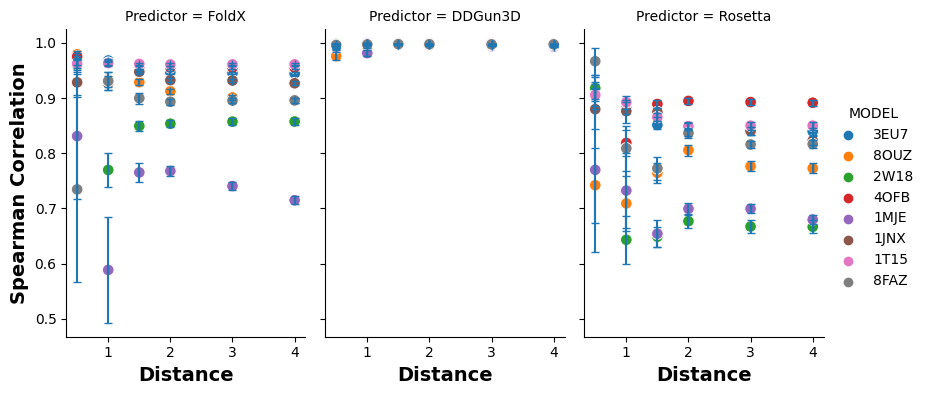

In [107]:
per_distance_df[['GENE', "MODEL"]] = per_distance_df['MODEL GENE'].str.split("_", expand=True)
plt.figure(figsize=(10, 16))
g = sns.FacetGrid(per_distance_df, col="Predictor",  col_wrap=3, height=4, aspect=.7)
g.map_dataframe(sns.scatterplot, y='PCC', x='DIST',  hue='MODEL',s=70)
g.map(plt.errorbar, "DIST", "PCC", "Error", marker="|", fmt='o',capsize=3)

g.set_ylabels('Spearman Correlation', fontsize=14, fontweight='bold')
g.set_xlabels('Distance', fontsize=14, fontweight='bold')
g.add_legend(title="MODEL")
plt.savefig('ddg_distance_correlation.png', dpi=300)
plt.show()
# Show the plot


In [112]:

mut_delta_foldx_df = mut_delta_df[(mut_delta_df['delta_FoldX'] > 2) | (mut_delta_df['delta_FoldX'] < -2)]
mut_delta_foldx_df = mut_delta_foldx_df[['mutations', 'GENE_MODEL', 'delta_FoldX']]

def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def filter_and_count_alt(check_df, column, cutoff):
    aro_list = ['W', 'Y', "H", "F"]
    check_df = check_df[['mutations', column]]
    check_df['REF'] = check_df['mutations'].str[0]
    check_df['POS'] = check_df['mutations'].apply(lambda x: extract_integers(x)[0])
    check_df['ALT'] = check_df['mutations'].str[-1]
    check_df = check_df.sort_values(by='POS')
    check_filter_df = check_df[(check_df[column] > cutoff) | (check_df[column] < -cutoff)]
    alt_counts = pd.DataFrame(check_filter_df['ALT'].value_counts())
    alt_counts = alt_counts.reset_index()
    alt_counts.columns = ['AminoAcid', 'Counts']
    alt_counts['Group'] = alt_counts['AminoAcid'].apply(lambda x: 1 if x in aro_list else 0)
    group_0_counts = alt_counts[alt_counts['Group'] == 0]['Counts']
    total_non_aro_count = sum(group_0_counts)
    group_1_counts = alt_counts[alt_counts['Group'] == 1]['Counts']
    total_aro_count = sum(group_1_counts)
    t_statistic, p_value = ttest_ind(group_0_counts, group_1_counts)
    return total_non_aro_count, total_aro_count, p_value
    


In [113]:
grouped_threshold_df = grouped_df[['GENE_MODEL', 'delta_FoldX_threshold', 'delta_DDgun3D_threshold', 'delta_Rosetta_threshold']]
for model in grouped_threshold_df.GENE_MODEL.tolist():
    foldx_threshold = grouped_threshold_df[grouped_threshold_df['GENE_MODEL'] == model]['delta_FoldX_threshold'].values[0]
    total_non_aro_count, total_aro_count, p = filter_and_count_alt(mut_delta_df, 'delta_FoldX', foldx_threshold)
    print(model, total_non_aro_count, total_aro_count, p)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


BRCA1_1JNX 296 588 6.85947061164109e-08
BRCA1_1T15 1072 1284 5.495174842316667e-08
BRCA1_4OFB 400 742 5.2423403982068606e-08
BRCA1_7LYB 724 1041 3.117456246387027e-08
BRCA2_1MJE 181 442 2.446965061651612e-07
PALB2_2W18 624 948 3.539859816235858e-08
PALB2_3EU7 625 948 3.5575405051748193e-08
RAD51C_8FAZ 1626 1605 2.7592037232936397e-07
RAD51C_8OUZ 354 684 3.48419966006495e-08
